Embedding human Uniprot by using ESM2

In [ ]:
"""
Embed proteins from a FASTA file using ESM-2 via HuggingFace transformers.

Outputs:
- embeddings.npy  (shape: [N, D])
- ids.npy         (shape: [N])

Run in your 'vae' environment after installing:
    pip install transformers torch biopython numpy
"""

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from Bio import SeqIO

# -------------------- USER SETTINGS --------------------
FASTA_PATH = r"F:\human.fasta"          # <-- change to your FASTA
OUT_EMB_PATH = r"embeddings.npy"
OUT_IDS_PATH = r"ids.npy"

MODEL_NAME = "facebook/esm2_t33_650M_UR50D"   # big ESM-2; you can choose smaller
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4  # increase if you have more GPU memory
# ------------------------------------------------------


def load_fasta(path):
    """Return (ids, sequences) from a FASTA file."""
    records = list(SeqIO.parse(path, "fasta"))
    if not records:
        raise ValueError(f"No sequences found in FASTA: {path}")

    ids = [rec.id for rec in records]
    seqs = [str(rec.seq).upper().replace("*", "") for rec in records]
    return ids, seqs


def mean_pool_last_hidden(hidden_states, attention_mask):
    """
    Mean-pool last_hidden_state over non-padding tokens using attention_mask.

    hidden_states: [B, L, D]
    attention_mask: [B, L]
    returns: [B, D]
    """
    mask = attention_mask.unsqueeze(-1)  # [B, L, 1]
    masked_hidden = hidden_states * mask  # zero out pads
    sum_hidden = masked_hidden.sum(dim=1)  # [B, D]
    lengths = mask.sum(dim=1)             # [B, 1]
    lengths = torch.clamp(lengths, min=1) # avoid div-by-zero
    return sum_hidden / lengths


def main():
    print(f"Loading tokenizer and model: {MODEL_NAME}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)
    model.eval()

    print(f"Reading FASTA from: {FASTA_PATH}")
    ids, seqs = load_fasta(FASTA_PATH)
    n = len(seqs)
    print(f"Found {n} sequences.")

    all_embeddings = []

    with torch.no_grad():
        for start in range(0, n, BATCH_SIZE):
            end = min(start + BATCH_SIZE, n)
            batch_seqs = seqs[start:end]

            # Tokenize batch with padding & truncation
            enc = tokenizer(
                batch_seqs,
                return_tensors="pt",
                padding=True,
                truncation=True,
                add_special_tokens=True,
            )

            input_ids = enc["input_ids"].to(DEVICE)
            attention_mask = enc["attention_mask"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state  # [B, L, D]

            # Mean-pool over non-padding tokens
            pooled = mean_pool_last_hidden(last_hidden, attention_mask)  # [B, D]

            all_embeddings.append(pooled.cpu().numpy())

            print(f"Processed {end}/{n} sequences")

    embeddings = np.concatenate(all_embeddings, axis=0)  # [N, D]
    ids_array = np.array(ids, dtype=object)

    print(f"Final embeddings shape: {embeddings.shape}")
    print(f"Saving embeddings to: {OUT_EMB_PATH}")
    print(f"Saving IDs to:        {OUT_IDS_PATH}")

    np.save(OUT_EMB_PATH, embeddings)
    np.save(OUT_IDS_PATH, ids_array)

    print("Done.")


if __name__ == "__main__":
    main()


Mapping IDs to the embedding space

In [2]:
import numpy as np
import pandas as pd

# ============================
# Load files
# ============================
path = r"F:\20251115\embeddings"

emb = np.load(f"{path}/embeddings.npy")              # numeric array
ids  = np.load(f"{path}/ids.npy", allow_pickle=True) # FIX: allow_pickle=True

print("Embeddings shape:", emb.shape)
print("IDs shape:", ids.shape)

# Convert bytes → str if needed
ids = np.array([x.decode("utf-8") if isinstance(x, bytes) else str(x) for x in ids])

# ============================
# Map IDs → Embeddings
# ============================
id_to_emb = {ids[i]: emb[i] for i in range(len(ids))}

# Example
example_id = ids[0]
print("\nExample ID:", example_id)
print("Embedding (first 5 dims):", id_to_emb[example_id][:5])

# ============================
# Optional: DataFrame
# ============================
df = pd.DataFrame(emb, index=ids)
df.index.name = "UniProt_ID"

print("\nDataFrame head:")
print(df.head())

# ============================
# Lookup function
# ============================
def get_embedding(acc):
    if acc not in id_to_emb:
        print(f"ID '{acc}' not found.")
        return None
    return id_to_emb[acc]

# Example lookup
acc = example_id
vec = get_embedding(acc)
print(f"\nEmbedding for {acc}:", vec[:10])


Embeddings shape: (20420, 320)
IDs shape: (20420,)

Example ID: sp|A0A087X1C5|CP2D7_HUMAN
Embedding (first 5 dims): [ 0.02453518 -0.11305591  0.26878786  0.00620046  0.18217029]

DataFrame head:
                                0         1         2         3         4    \
UniProt_ID                                                                    
sp|A0A087X1C5|CP2D7_HUMAN  0.024535 -0.113056  0.268788  0.006200  0.182170   
sp|A0A0B4J2F0|PIOS1_HUMAN -0.047362  0.116605  0.398205  0.322381 -0.096056   
sp|A0A0C5B5G6|MOTSC_HUMAN  0.011769 -0.350674  0.207823  0.394139  0.058624   
sp|A0A0K2S4Q6|CD3CH_HUMAN -0.173922 -0.176102 -0.102152  0.086047  0.273279   
sp|A0A0U1RRE5|NBDY_HUMAN   0.046170 -0.635303 -0.009137  0.190436  0.156774   

                                5         6         7         8         9    \
UniProt_ID                                                                    
sp|A0A087X1C5|CP2D7_HUMAN -0.175346  0.046930 -0.142103 -0.437160  0.076005   
sp|A0A0B4J2F0|

Dimensionality reduction

TF version: 2.17.0
Embeddings shape: (20420, 320)
IDs shape: (20420,)
PCA 2D shape: (20420, 2)


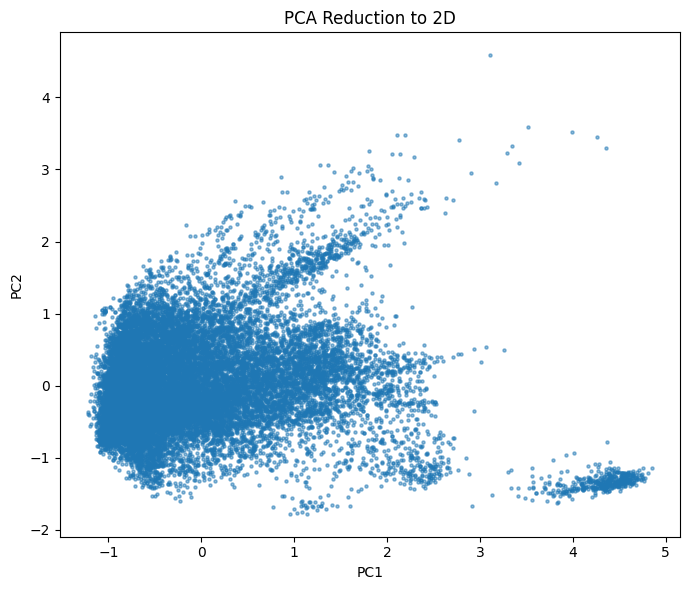

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │     82,176 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │     32,896 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 115,588 (451.52 KB)

 Trainable params: 115,588 (451.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 320)            │        82,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,648 (451.75 KB)

 Trainable params: 115,648 (451.75 KB)

 Non-trainable params: 0 (0.00 B)

Training VAE…
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - kl_loss: 1.3531 - loss: 12.0974 - recon_loss: 10.7443
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - kl_loss: 0.4806 - loss: 4.4387 - recon_loss: 3.9581
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 0.4479 - loss: 4.3343 - recon_loss: 3.8864
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 0.4425 - loss: 4.3146 - recon_loss: 3.8721
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 0.4500 - loss: 4.3126 - recon_loss: 3.8626
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 0.4545 - loss: 4.3156 - recon_loss: 3.8611
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 0.4570 - loss: 4.3048 - recon_loss: 3.8477
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 0.4497 - loss: 4.3021 - recon_loss: 3.8523
Epoch 9/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 0.4446 - loss: 4.2830 - recon_loss: 3.8384
Epoch 10/30
160/160 ━━━━━━━

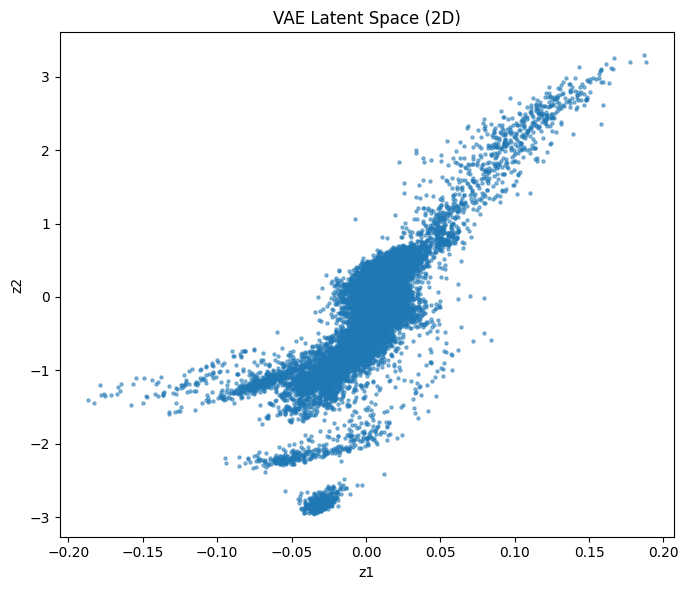

Saved 2D embeddings to:
  F:\20251115\embeddings\embeddings_pca_2d.npy
  F:\20251115\embeddings\embeddings_vae_2d.npy


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

import tensorflow as tf
from tensorflow.keras import layers, Model

tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)


print("TF version:", tf.__version__)

# =========================================================
# Load embeddings + IDs
# =========================================================
path = r"F:\20251115\embeddings"

emb = np.load(f"{path}/embeddings.npy")
ids = np.load(f"{path}/ids.npy", allow_pickle=True)
ids = np.array([x.decode("utf-8") if isinstance(x, bytes) else str(x) for x in ids])

emb = emb.astype("float32")

print("Embeddings shape:", emb.shape)   # (N, D)
print("IDs shape:", ids.shape)

# =========================================================
# PCA → 2D
# =========================================================
pca = PCA(n_components=2)
emb_pca_2d = pca.fit_transform(emb)

print("PCA 2D shape:", emb_pca_2d.shape)

plt.figure(figsize=(7, 6))
plt.scatter(emb_pca_2d[:, 0], emb_pca_2d[:, 1], s=5, alpha=0.5)
plt.title("PCA Reduction to 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# =========================================================
# VAE → 2D using tf.keras.Model subclass
# =========================================================
original_dim = emb.shape[1]
latent_dim = 2

# ---------- Encoder ----------
encoder_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_m, z_lv = inputs
        batch = tf.shape(z_m)[0]
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        return z_m + tf.exp(0.5 * z_lv) * epsilon

z = Sampling(name="z")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# ---------- Decoder ----------
latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
y = layers.Dense(128, activation="relu")(latent_inputs)
y = layers.Dense(256, activation="relu")(y)
decoder_outputs = layers.Dense(original_dim, activation=None, name="decoder_output")(y)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# ---------- VAE model ----------
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.recon_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # Reconstruction loss: L2 per sample
            recon_loss = tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            recon_loss = tf.reduce_mean(recon_loss)

            # KL divergence
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

vae = VAE(encoder, decoder, name="vae")
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("Training VAE…")
vae.fit(emb, epochs=30, batch_size=128, verbose=1)

# ---------- Get 2D latent coords (use z_mean) ----------
z_mean_vals, z_log_var_vals, z_vals = encoder.predict(emb, batch_size=256)
print("VAE 2D shape:", z_mean_vals.shape)

plt.figure(figsize=(7, 6))
plt.scatter(z_mean_vals[:, 0], z_mean_vals[:, 1], s=5, alpha=0.5)
plt.title("VAE Latent Space (2D)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.tight_layout()
plt.show()

# =========================================================
# Save outputs
# =========================================================
np.save(f"{path}/embeddings_pca_2d.npy", emb_pca_2d)
np.save(f"{path}/embeddings_vae_2d.npy", z_mean_vals)

print("Saved 2D embeddings to:")
print(f"  {path}\\embeddings_pca_2d.npy")
print(f"  {path}\\embeddings_vae_2d.npy")


Find the closest proteins and plot them in VAE

Sample extracted accession: [None None None None None None None None None None]

Query: P37840
Top 10 closest proteins:
 1. sp|Q16143|SYUB_HUMAN                                sim = 0.9828
 2. sp|O76070|SYUG_HUMAN                                sim = 0.9772
 3. sp|B3EWG5|FM25C_HUMAN                               sim = 0.9450
 4. sp|B3EWG6|FM25G_HUMAN                               sim = 0.9450
 5. sp|B3EWG3|FM25A_HUMAN                               sim = 0.9450
 6. sp|Q8WUH6|TM263_HUMAN                               sim = 0.9381
 7. sp|Q99541|PLIN2_HUMAN                               sim = 0.9124
 8. sp|P55327|TPD52_HUMAN                               sim = 0.9109
 9. sp|Q6UXV4|MIC27_HUMAN                               sim = 0.9068
10. sp|Q15847|ADIRF_HUMAN                               sim = 0.9057


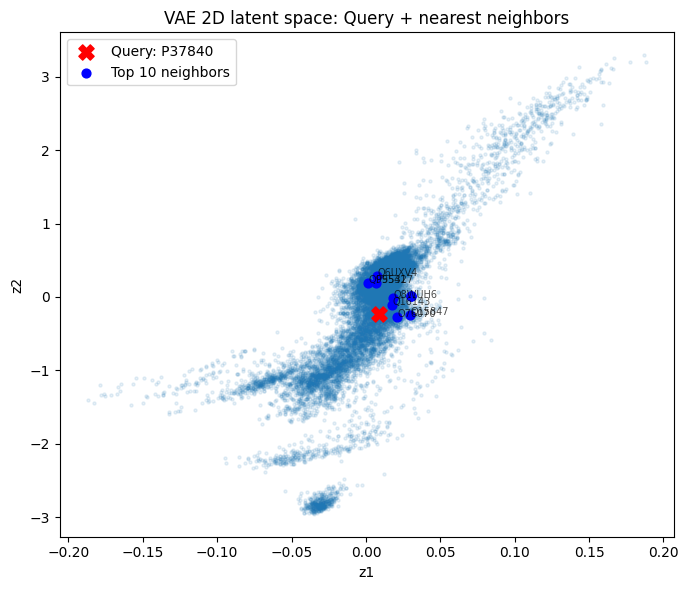

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import re

# =========================================
# Load data
# =========================================
path = r"F:\20251115\embeddings"

emb = np.load(f"{path}/embeddings.npy").astype("float32")
ids_raw = np.load(f"{path}/ids.npy", allow_pickle=True)
ids_raw = np.array([x.decode("utf-8") if isinstance(x, bytes) else str(x) 
                    for x in ids_raw])

vae_2d = np.load(f"{path}/embeddings_vae_2d.npy")

# =========================================
# Extract accessions using regex
# =========================================
# Example matches: P37840, Q9Y6X5, A0A023X, etc.
acc_regex = re.compile(r"[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]{5}")

accessions = []
for s in ids_raw:
    m = acc_regex.search(s)
    if m:
        accessions.append(m.group(0))
    else:
        accessions.append(None)

accessions = np.array(accessions)

print("Sample extracted accession:", accessions[:10])

# Build index lookup for accessions
acc_to_idx = {}
for i, acc in enumerate(accessions):
    if acc is not None:
        acc_to_idx.setdefault(acc, []).append(i)

# Pre-normalize embeddings for cosine similarity
norms = np.linalg.norm(emb, axis=1, keepdims=True)
emb_norm = emb / (norms + 1e-12)

# =========================================
# Top-k nearest neighbors
# =========================================
def get_top_k_neighbors(accession, k=10):
    if accession not in acc_to_idx:
        print(f"Accession '{accession}' not found in extracted IDs.")
        return None, None

    # If multiple identical accessions, just use the first occurrence
    idx = acc_to_idx[accession][0]

    q_vec = emb_norm[idx]

    sims = emb_norm @ q_vec
    sims[idx] = -1.0

    top_idx = np.argsort(-sims)[:k]
    top_ids = ids_raw[top_idx]
    top_sims = sims[top_idx]

    print(f"\nQuery: {accession}")
    print("Top 10 closest proteins:")
    for rank, (tid, sim) in enumerate(zip(top_ids, top_sims), 1):
        print(f"{rank:2d}. {tid:50s}  sim = {sim:.4f}")

    return idx, top_idx

# =========================================
# Plot on VAE
# =========================================
def plot_on_vae(query_idx, neighbor_indices, accession):
    plt.figure(figsize=(7, 6))

    plt.scatter(vae_2d[:, 0], vae_2d[:, 1], s=5, alpha=0.1)

    plt.scatter(
        vae_2d[query_idx, 0],
        vae_2d[query_idx, 1],
        s=120, c="red", marker="X",
        label=f"Query: {accession}"
    )

    plt.scatter(
        vae_2d[neighbor_indices, 0],
        vae_2d[neighbor_indices, 1],
        s=40, c="blue",
        label="Top 10 neighbors"
    )

    for i in neighbor_indices:
        plt.text(
            vae_2d[i, 0],
            vae_2d[i, 1],
            accessions[i],
            fontsize=7,
            alpha=0.7
        )

    plt.title("VAE 2D latent space: Query + nearest neighbors")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================================
# Ask for accession
# =========================================
acc = input("Enter UniProt accession (e.g., P37840): ").strip()

query_idx, neighbor_idx = get_top_k_neighbors(acc, k=10)
if query_idx is not None:
    plot_on_vae(query_idx, neighbor_idx, acc)
